# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**

This project aims to forecast national monthly car sales in South Africa (who: automotive industry stakeholders) by integrating historical vehicle sales data with behavioral signals from Google Trends search indices (what). Using data spanning from 2010 Jan to 2025 Jan (when) and focusing on the South African automotive market (where), the study addresses why traditional forecasting methods—based only on past sales—often fail to capture rapid shifts in consumer interest and external market changes. To overcome this, the research compares traditional time-series models (SARIMA, LSSVR) with deep learning models (LSTM, CNN-LSTM, BiLSTM), both with and without online search data, to evaluate the added predictive value of behavioral signals (how). Finally, the best-performing deep learning models are interpreted using SHAP analysis to reveal which features most influence forecasts, supporting more data-driven, transparent, and responsive decision-making for manufacturers, dealerships, and analysts.

#### **Datasets:**

<table style="width:100%">
  <thead>
    <tr>
      <th>Name</th>
      <th>Start Date</th>
      <th>End Date</th>
      <th>Source</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Motor Trade Sales.xlsx</td>
      <td>01-1998</td>
      <td>05-2025</td>
      <td>CEIC Data</td>
      <td>Revenue generated each month from sales</td>
    </tr>
    <tr>
      <td>Motor Vehicle Sales Monthly South Africa.xlsx</td>
      <td>01-2003</td>
      <td>06-2025</td>
      <td>CEIC Data</td>
      <td>Number of units sold each month</td>
    </tr>
    <tr>
      <td>Autos_Vehicles_Category.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The overall interest in the Autos Vehicles category on Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising topics related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top topics related to the automotive category in Google Trends</td>
    </tr>
  </tbody>
</table>


##### **Important Descriptions**
+ Interest over time from Google Trends:

    *Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term.*

## 1. Libraries

In [2]:
#! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prettytable

# Tensorflow for CPU users
#! pip install tensorflow

In [50]:
import itertools
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, joblib
import openpyxl
import tensorflow as tf
import keras
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Bidirectional
from keras.callbacks import EarlyStopping
from scipy.signal import windows, savgol_filter

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR

## 2. Importing datasets

In [146]:
sales = pd.read_excel("Motor Trade Sales.xlsx", sheet_name="My Series")

vol = pd.read_excel("Motor Vehicle Sales Monthly South Africa.xlsx",  sheet_name="My Series")

In [147]:
print(sales.info())
print("="*50)
print(vol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    329 non-null    datetime64[ns]
 1   Sales   329 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    270 non-null    datetime64[ns]
 1   Volume  270 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.3 KB
None


In [148]:
# Google trends data preperation
def load_and_merge_google_trends_data(folder_path):
    merged_df = None
    folder = Path(folder_path)
    
    for file in folder.glob("*.csv"):
        keyword = file.stem  # Get filename without extension
        df = pd.read_csv(file, skiprows=2)
        
        # Rename the value column using the keyword (assumes 2 columns: Month + keyword)
        if df.shape[1] > 1:
            df.columns = ['Month', keyword]
        else:
            continue  # skip malformed file

        # Merge into final dataset
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Month', how='outer')

    # Optional: sort by Month
    if merged_df is not None:
        merged_df.sort_values('Month', inplace=True)
    
    return merged_df


# Example usage:
base_path = "./GoogleTrends"
output_dir = "./Processed_Trends"
os.makedirs(output_dir, exist_ok=True)

folders = {
    "queries_rising": os.path.join(base_path, "Queries", "Rising"),
    "queries_top": os.path.join(base_path, "Queries", "Top"),
    "topics_rising": os.path.join(base_path, "Topics", "Rising"),
    "topics_top": os.path.join(base_path, "Topics", "Top")
}

# Process and save
for name, path in folders.items():
    merged = load_and_merge_google_trends_data(path)
    if merged is not None:
        merged.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)
        print(f"Saved: {name}.csv")
    else:
        print(f"No data found for: {name}")

Saved: queries_rising.csv
Saved: queries_top.csv
Saved: topics_rising.csv
Saved: topics_top.csv


## 3. Data Preparation

   1. We will limit the range of observation to 01-2004 to 05-2025, since that is where they all overlap. (This will act as a form of balancing the datasets)
   2. Make sure the "Date" column is in datetime format, and is the index of the dataframe.
   3. Shift the days to the last of the month

In [149]:
def limit_date_range(df, date_column):
    # Replace "<1" values (strings) with 0 across all columns
    df.replace("<1", 0, inplace=True)
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format='%Y-%m')
    # Shift dates to end of month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp('M')
    # Define boundaries
    start_date = pd.to_datetime('2004-01')
    end_date = pd.to_datetime('2025-05')
    # Filter by date range
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    return df


sales = limit_date_range(sales, 'Date')
vol = limit_date_range(vol, 'Date')

# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter to all CSVs in folder
for file in Path(folder_path).glob("*.csv"):
    try:
        final_df = pd.read_csv(file)
        # Rename 'Month' column to 'Date'
        if 'Month' in final_df.columns:
            final_df.rename(columns={'Month': 'Date'}, inplace=True)
        # Limit date range
        df_filtered = limit_date_range(final_df, 'Date')
        
        # Save the filtered dataframe
        out_file = Path(folder_path) / file.name
        df_filtered.to_csv(out_file, index=False)
        print(f"Filtered and saved: {out_file.name}")
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

Filtered and saved: queries_rising.csv
Filtered and saved: queries_top.csv
Filtered and saved: topics_rising.csv
Filtered and saved: topics_top.csv


In [150]:
# Here will will set the index of sales and vol dataframes to 'Date'
sales.set_index("Date", inplace=True)
vol.set_index("Date", inplace=True)

In [151]:
# Combining both series into one DataFrame
combined_df = pd.concat([
    sales.rename(columns={sales.columns[0]: 'Sales (Rmn)'}),
    vol.rename(columns={vol.columns[0]: 'Volume'})
], axis=1)

# Reset index to get date as a column
combined_df = combined_df.reset_index().rename(columns={'index': 'Date'})

# Melt to long format for seaborn lineplot
long_df = combined_df.melt(id_vars='Date', value_vars=['Sales (Rmn)', 'Volume'], 
                           var_name='Type', value_name='Value')

## 4. Data Understanding

### a. Time Series Plots

#### (i) Sales and Volume Time Series Plots

In [152]:
# Create interactive Plotly line chart
fig = px.line(
    long_df,
    x='Date',
    y='Value',
    color='Type',
    title='Sales and Volume Over Time',
    labels={'Value': 'Value/Count', 'Date': 'Date', 'Type': 'Legend'}
)

# Optional: Style tweaks
fig.update_layout(
    template='plotly_white',
    legend_title_text='Type',
    xaxis_title='Date',
    yaxis_title='Value/Count'
)

# Show the plot
fig.show()


##### *Interpretation:*

The graph shows an overall increase in sales (in millions) over the year with the volume of vehicles sold remaining in the 20-60 thousand range. In the early 2000's the volume of vehicles sold was more than the money generated, and it started maintaing the same trend up until 2016. After this the industry started focusing on maximizing profit. 

In early 2020, there was a sharp decline in both sales and volume. This was caused by the shut down of the country due to the Covid-19 Pandemic.[https://www.cars.co.za/motoring-news/new-car-sales-in-sa-march-2020/77385/]

**Key Takeaway:**
The outputs have a clear outlier during the early days of Covid so we will need to remedy that at some point.

#### (ii) Google Trends Time Series Plots

In [153]:
# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter and plot all CSVs
for file in Path(folder_path).glob("*.csv"):
    try:
        # Load the CSV and parse the index as datetime
        final_df = pd.read_csv(file, index_col=0, parse_dates=True)

        # Reset index to make 'Date' a column for Plotly
        df_reset = final_df.reset_index().rename(columns={final_df.index.name: 'Date'})

        # Melt to long format
        df_melted = df_reset.melt(id_vars='Date', var_name='Keyword', value_name='Interest')

        # Plot with Plotly
        fig = px.line(
            df_melted,
            x='Date',
            y='Interest',
            color='Keyword',
            title=f"{file.stem} Trends",
            labels={'Interest': 'Interest Level', 'Date': 'Date', 'Keyword': 'Keyword'}
        )

        fig.update_layout(
            template='plotly_white',
            legend_title_text='Keyword',
            xaxis_title='Date',
            yaxis_title='Interest Level'
        )

        fig.show()

    except Exception as e:
        print(f"Failed to plot {file.name}: {e}")

##### *Interpretation:*

So far all the graphs for the Google trends data is nonsensical, we will have to dig deeper at a later stage to extract some information from them.

### b. STL Plots for Sales and Volume

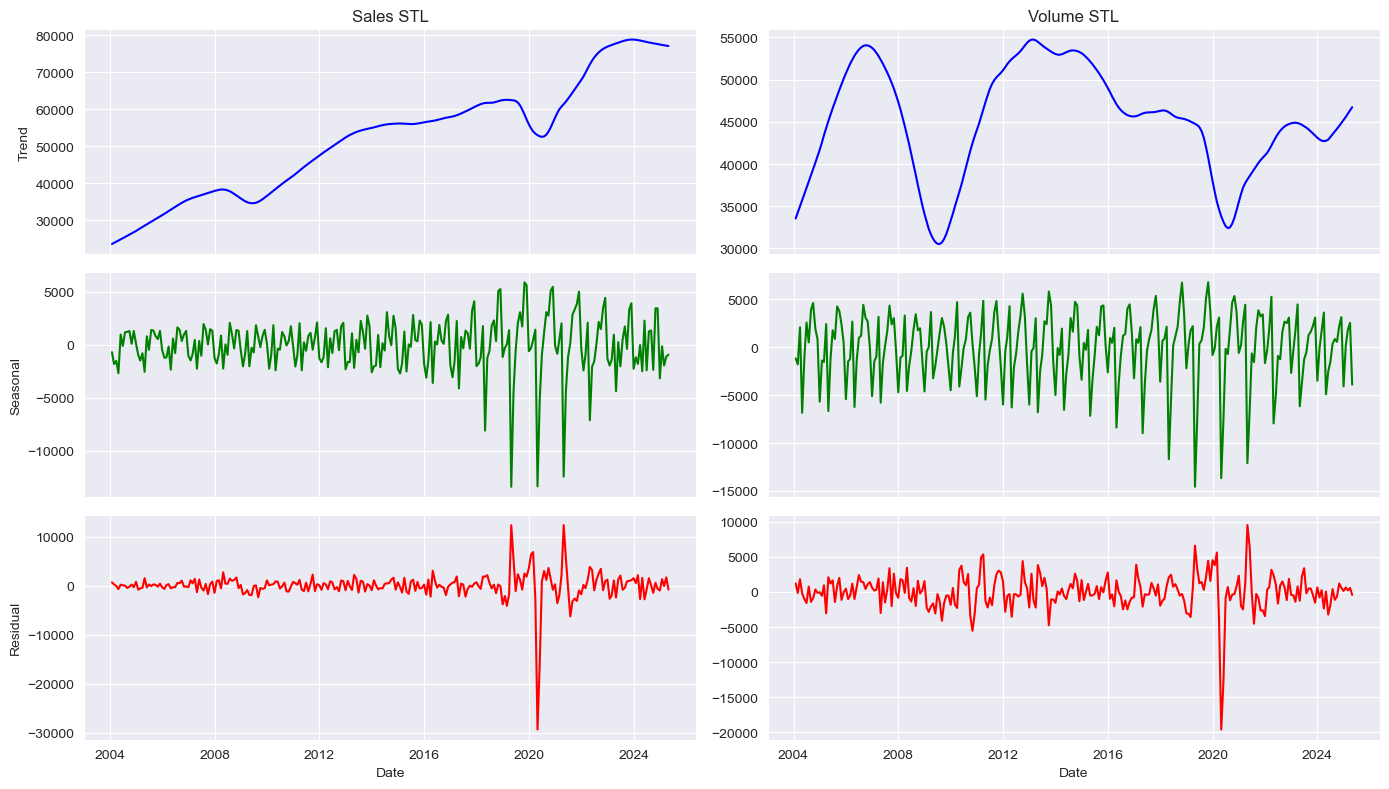

In [154]:
# Perform STL decomposition
stl_sales = STL(sales['Sales'], period=12).fit()
stl_vol = STL(vol['Volume'], period=12).fit()

# Create side-by-side subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True)

# Titles for each subplot column
axes[0, 0].set_title('Sales STL')
axes[0, 1].set_title('Volume STL')

# Plot Trend
axes[0, 0].plot(stl_sales.trend, label='Trend', color='blue')
axes[0, 1].plot(stl_vol.trend, label='Trend', color='blue')

# Plot Seasonal
axes[1, 0].plot(stl_sales.seasonal, label='Seasonal', color='green')
axes[1, 1].plot(stl_vol.seasonal, label='Seasonal', color='green')

# Plot Residual
axes[2, 0].plot(stl_sales.resid, label='Residual', color='red')
axes[2, 1].plot(stl_vol.resid, label='Residual', color='red')

# Y-axis labels
axes[0, 0].set_ylabel('Trend')
axes[1, 0].set_ylabel('Seasonal')
axes[2, 0].set_ylabel('Residual')

# X-axis label on bottom row
axes[2, 0].set_xlabel('Date')
axes[2, 1].set_xlabel('Date')

# Tight layout
plt.tight_layout()
plt.show()


##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>Sales</strong></th>
      <th style="padding:8px;"><strong>Volume</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Trend</strong></td>
      <td style="padding:8px;">
        There’s a clear upward trend from 2004 to around 2015, followed by a plateau between 2015–2018.
        A sharp dip is observed in 2020 (COVID-19), with strong recovery post-2021 and slight softening at the end.
      </td>
      <td style="padding:8px;">
        Starts high, rises until ~2006, then declines to 2009. Stabilizes between 2010–2016,
        then dips sharply in 2020 (pandemic) with partial recovery after. More volatile than Sales.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Seasonality</strong></td>
      <td style="padding:8px;">
        Strong and consistent annual cycles. Peaks and troughs repeat regularly with slightly amplified fluctuations post-2019.
      </td>
      <td style="padding:8px;">
        Seasonal swings are more intense than in Sales. Regular cycles persist but become more erratic post-2020.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Residuals</strong></td>
      <td style="padding:8px;">
        Mostly stable around zero, with outliers during 2020 (COVID shock). Suggests low noise and well-behaved time series.
      </td>
      <td style="padding:8px;">
        Similar residual shape as Sales, but with slightly higher volatility and noise, especially post-2018.
        Strong outliers in 2020.
      </td>
    </tr>
  </tbody>
</table>


### c. ACF/PACF Plots for volume and sales

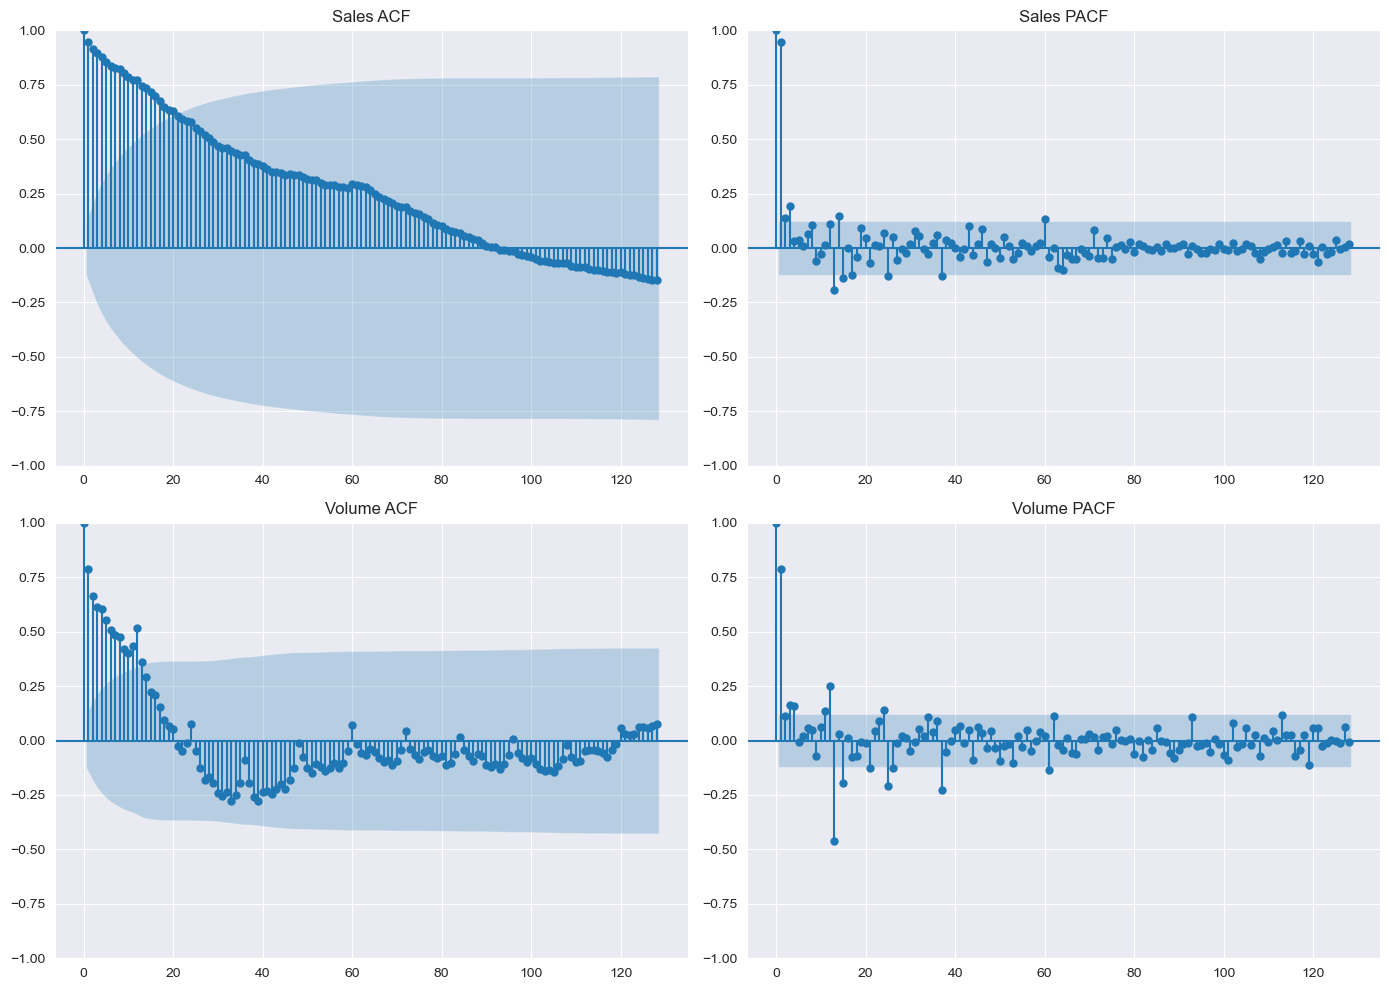

In [155]:
# Assuming sales and vol are DataFrames with one column each:
sales_series = sales["Sales"]
vol_series = vol["Volume"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sales ACF
plot_acf(sales_series, ax=axes[0, 0], lags=len(vol)//2)
axes[0, 0].set_title('Sales ACF')

# Sales PACF
plot_pacf(sales_series, ax=axes[0, 1], lags=len(vol)//2, method='ywm')
axes[0, 1].set_title('Sales PACF')

# Volume ACF
plot_acf(vol_series, ax=axes[1, 0], lags=len(vol)//2)
axes[1, 0].set_title('Volume ACF')

# Volume PACF
plot_pacf(vol_series, ax=axes[1, 1], lags=len(vol)//2, method='ywm')
axes[1, 1].set_title('Volume PACF')

plt.tight_layout()
plt.show()

##### **Intepretation:**

<table style="width:100%; border-collapse: collapse;" border="1">
  <thead>
    <tr>
      <th style="padding:8px;"><strong>Component</strong></th>
      <th style="padding:8px;"><strong>ACF</strong></th>
      <th style="padding:8px;"><strong>PACF</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;"><strong>Sales</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at at very low lags then slowly declining toward zero. This suggests that current sales vales are heavily dependent on previous sales values (Non-Stationarity)
      </td>
      <td style="padding:8px;">
        There is a large spike at lag 1, followed by much smaller spikes within confidence bounds. This indicates that lag 1 has the strongest direct effect on current sales once other lags are controlled for.
      </td>
    </tr>
    <tr>
      <td style="padding:8px;"><strong>Volume</strong></td>
      <td style="padding:8px;">
        There is a High Positive Autocorrelation at low lags but decays faster compared to sales.
        There are also noticable oscillations around zero from lag 20 onwards, which confirms the seasonal patterns identified in the Seasonality plot. 
      </td>
      <td style="padding:8px;">
        There is a strong spike at lag 1, smaller spikes at lags 2 and beyond. Most other lags stay within the confidence interval, except for a few spikes. 
      </td>
    </tr>
  </tbody>
</table>

##### **Overall Conclusion:**

+ Therefore both figures need stationarity testing (ADF) before model fitting.

## 5. Final Data Preparation

### a. Dataset Merger

In [156]:
# remember we already have a dataset that has the sales and volume fields
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         256 non-null    datetime64[ns]
 1   Sales (Rmn)  256 non-null    int64         
 2   Volume       256 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.1 KB


In [157]:
# Ensure main DataFrame has Date as index
combined_df.set_index('Date', inplace=True)
final_df = combined_df.copy()

# Path to folder
folder_path = Path('./Processed_Trends')

for file in folder_path.glob("*.csv"):
    try:
        temp_df = pd.read_csv(file, index_col=0, parse_dates=True)
        suffix = file.stem.lower().replace(" ", "_")
        
        # Rename columns to avoid overlaps
        temp_df = temp_df.rename(columns={col: f"{col}_{suffix}" for col in temp_df.columns})
        
        # Merge temp_df into final_df
        final_df = final_df.join(temp_df, how='left')
        print(f"Merged: {file.name}")
        
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

print("Final combined shape:", final_df.shape)
final_df.head() 


Merged: queries_rising.csv
Merged: queries_top.csv
Merged: topics_rising.csv
Merged: topics_top.csv
Final combined shape: (256, 43)


,Sales (Rmn),Volume,ford_figo_queries_rising,golf_6_gti_queries_rising,golf_7_gti_queries_rising,gwm_queries_rising,hyundai_i10_queries_rising,hyundai_i20_queries_rising,polo_vivo_queries_rising,toyota_corolla_for_sale_queries_rising,...,toyota_fortuner_topics_rising,volkswagen_tiguan_topics_rising,audi_topics_top,bmw_topics_top,car_topics_top,ford_topics_top,mercedes_topics_top,toyota_topics_top,volkswagen_topics_top,volkwagen_polo_topics_top
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-31,23578,33601,0,0,0,0,0,0,0,0,...,0,0,42,63,76,29,54,45,67,0
2004-02-29,22343,32338,0,0,0,0,0,0,0,0,...,0,0,53,56,79,33,57,42,58,0
2004-03-31,22645,38892,100,0,0,0,0,0,0,0,...,0,0,45,59,76,39,53,44,35,0
2004-04-30,21155,28681,0,0,0,0,0,0,0,0,...,0,0,37,51,64,30,42,46,65,0
2004-05-31,26024,34347,0,0,0,0,0,0,0,0,...,0,0,37,55,75,31,54,48,58,0


### c. Outlier Management

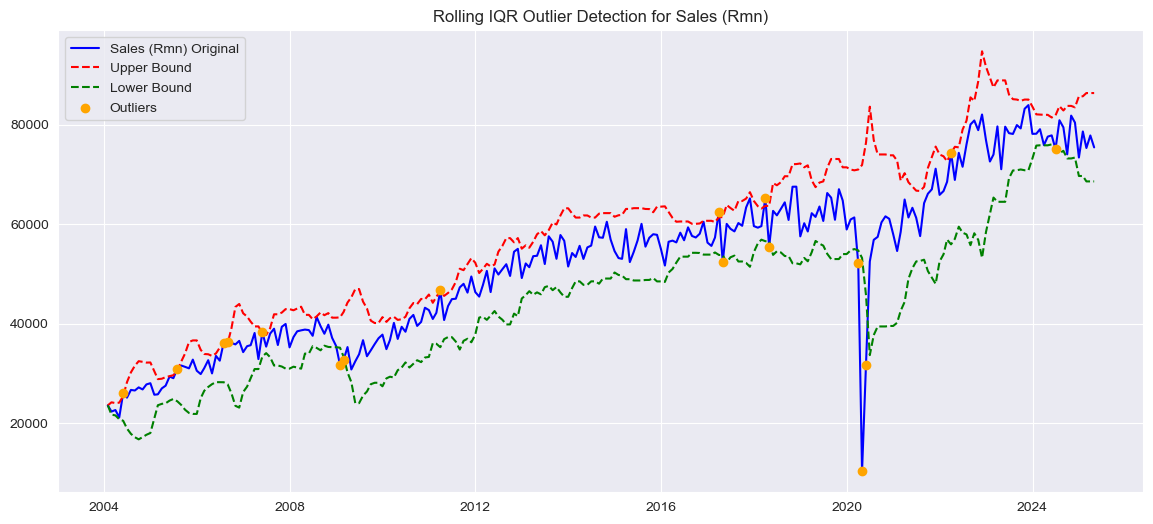

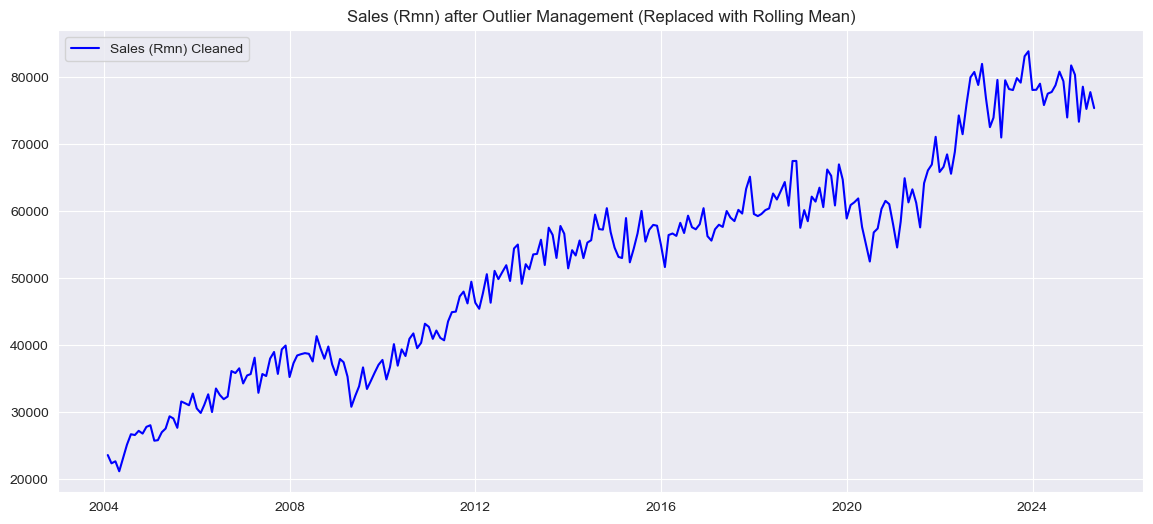

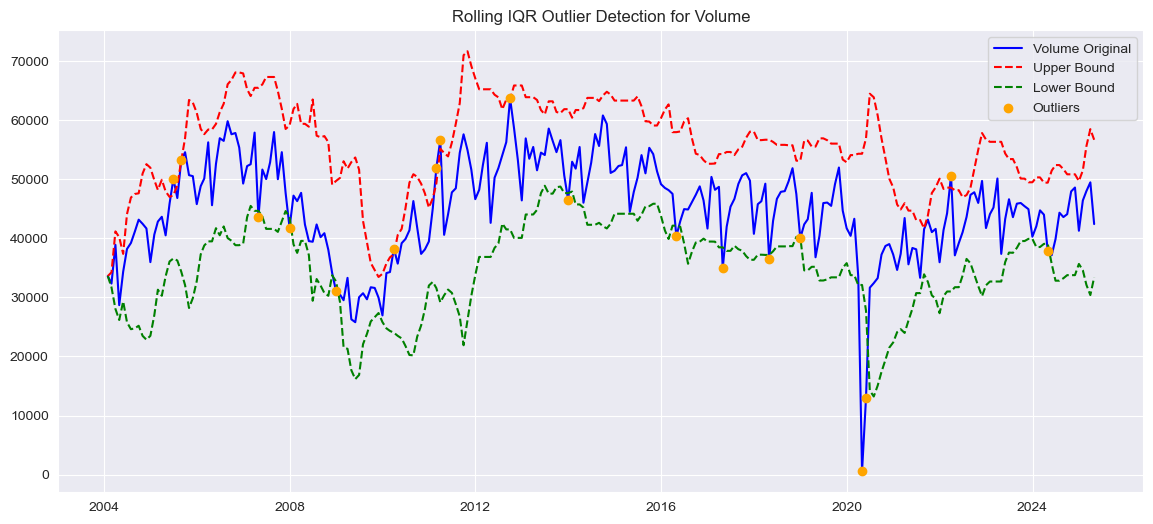

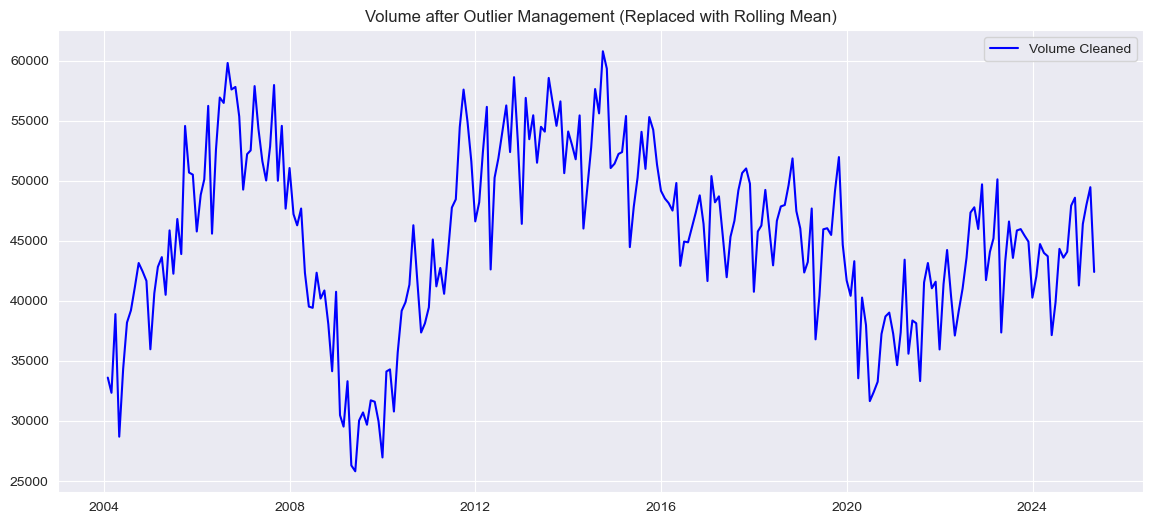

In [158]:
# Parameters
window = 12
columns_to_check = ['Sales (Rmn)', 'Volume']

for col in columns_to_check:
    # Rolling Q1, Q3, IQR
    rolling_Q1 = final_df[col].rolling(window=window, min_periods=1).quantile(0.25)
    rolling_Q3 = final_df[col].rolling(window=window, min_periods=1).quantile(0.75)
    rolling_IQR = rolling_Q3 - rolling_Q1
    
    lower_bound = rolling_Q1 - 1.5 * rolling_IQR
    upper_bound = rolling_Q3 + 1.5 * rolling_IQR
    
    outliers = (final_df[col] < lower_bound) | (final_df[col] > upper_bound)
    
    # Plot Original + Outliers
    plt.figure(figsize=(14,6))
    plt.plot(final_df.index, final_df[col], label=f'{col} Original', color='blue')
    plt.plot(final_df.index, upper_bound, color='red', linestyle='--', label='Upper Bound')
    plt.plot(final_df.index, lower_bound, color='green', linestyle='--', label='Lower Bound')
    plt.scatter(final_df.index[outliers], final_df[col][outliers], color='orange', label='Outliers', zorder=5)
    plt.legend()
    plt.title(f"Rolling IQR Outlier Detection for {col}")
    plt.show()
    
    # Replace Outliers with Rolling Mean
    rolling_mean = final_df[col].rolling(window=window, min_periods=1).mean()
    final_df.loc[outliers, col] = rolling_mean[outliers]
    
    # Plot Cleaned Series
    plt.figure(figsize=(14,6))
    plt.plot(final_df.index, final_df[col], label=f'{col} Cleaned', color='blue')
    plt.legend()
    plt.title(f"{col} after Outlier Management (Replaced with Rolling Mean)")
    plt.show()


### d. Denoising

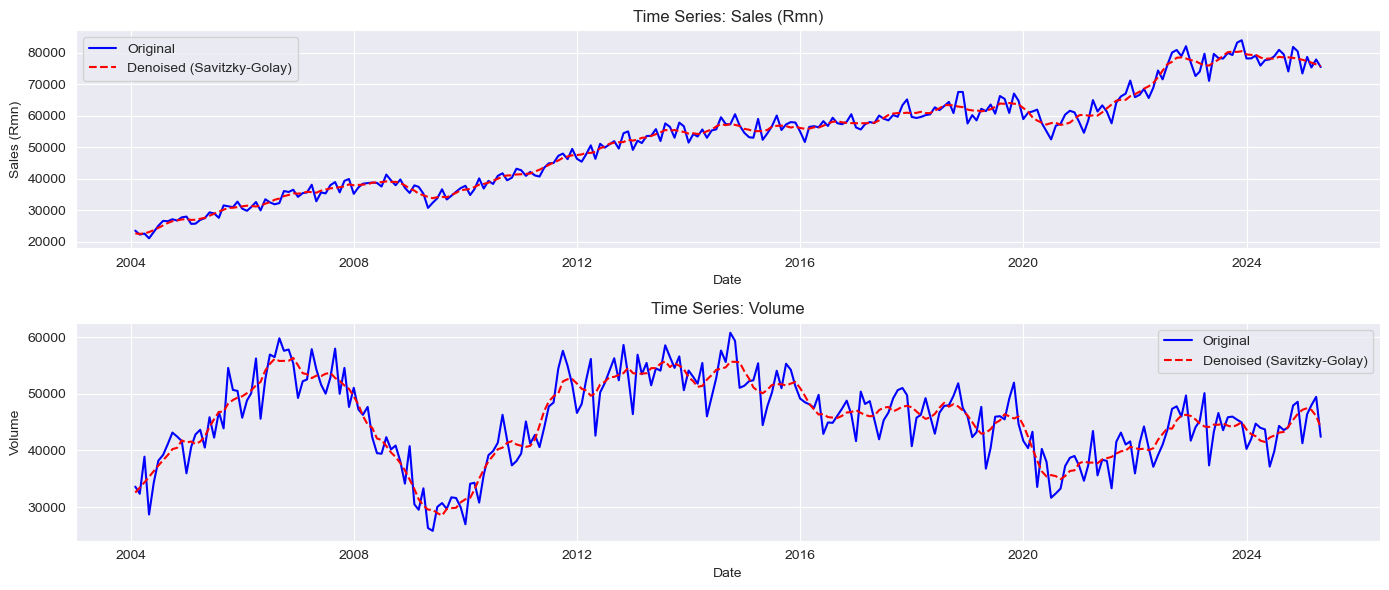

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def savgol_denoiser(df, columns=None, window_length=15, polyorder=3):
    """
    Apply Savitzky-Golay filter to smooth selected columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): Columns to denoise. If None, apply to all numeric.
        window_length (int): Length of the filter window (must be odd and > polyorder).
        polyorder (int): Polynomial order to fit within each window.
    """
    df_denoised = df.copy()
    if columns is None:
        columns = df.select_dtypes(include=np.number).columns.tolist()
    
    for col in columns:
        signal = df[col].values
        # Apply Savitzky-Golay filter
        denoised_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)
        df_denoised[col] = denoised_signal
    
    return df_denoised


# Apply to your data
denoised_df = savgol_denoiser(final_df, columns=["Sales (Rmn)", "Volume"], window_length=15, polyorder=3)

# Clean column names
final_df.columns = final_df.columns.str.strip()
denoised_df.columns = denoised_df.columns.str.strip()

# Plot comparison
columns_to_plot = ['Sales (Rmn)', 'Volume']
plt.figure(figsize=(14, 6))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 1, i)
    plt.plot(final_df.index, final_df[col], label='Original', color='blue')
    plt.plot(denoised_df.index, denoised_df[col], label='Denoised (Savitzky-Golay)', color='red', linestyle='--')
    plt.title(f'Time Series: {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

### e. Data Normalization

In [160]:
scaler = StandardScaler()
final_df_scaled = pd.DataFrame(
    scaler.fit_transform(final_df),
    index=final_df.index,
    columns=final_df.columns
)

In [161]:
final_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256 entries, 2004-01-31 to 2025-04-30
Data columns (total 43 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Sales (Rmn)                             256 non-null    float64
 1   Volume                                  256 non-null    float64
 2   ford_figo_queries_rising                256 non-null    float64
 3   golf_6_gti_queries_rising               256 non-null    float64
 4   golf_7_gti_queries_rising               256 non-null    float64
 5   gwm_queries_rising                      256 non-null    float64
 6   hyundai_i10_queries_rising              256 non-null    float64
 7   hyundai_i20_queries_rising              256 non-null    float64
 8   polo_vivo_queries_rising                256 non-null    float64
 9   toyota_corolla_for_sale_queries_rising  256 non-null    float64
 10  toyota_hilux_for_sale_queries_rising    256

## 6. Feature Importance and Selection

### a. ADF Test

In [162]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Run Augmented Dickey-Fuller test with clean output.
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # Drop NaN values
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis -> Stationary.\n")
    else:
        print("Weak evidence against the null hypothesis -> Non-stationary.\n")

# Run ADF for Sales and Volume
adf_test(final_df['Sales (Rmn)'], 'Sales (Rmn)')
adf_test(final_df['Volume'], 'Volume')

Augmented Dickey-Fuller Test: Sales (Rmn)
ADF Statistic            -1.006818
p-value                   0.750769
# Lags Used              15.000000
# Observations          240.000000
Critical Value (1%)      -3.457894
Critical Value (5%)      -2.873659
Critical Value (10%)     -2.573229
Weak evidence against the null hypothesis -> Non-stationary.

Augmented Dickey-Fuller Test: Volume
ADF Statistic            -3.788853
p-value                   0.003023
# Lags Used              14.000000
# Observations          241.000000
Critical Value (1%)      -3.457779
Critical Value (5%)      -2.873609
Critical Value (10%)     -2.573202
Strong evidence against the null hypothesis -> Stationary.



##### Conclusion:

- we need to remove the trend and seasonality from 'Sales (Rmn)' variable since it is non-stationary

In [163]:
# First-order differencing
final_df['Sales (Rmn)'] = final_df['Sales (Rmn)'].diff().diff(12)

# Drop NA from differencing
final_df = final_df.dropna()

# Re-run ADF test on differenced series
adf_test(final_df['Sales (Rmn)'], 'Sales (Rmn) - First Difference')


Augmented Dickey-Fuller Test: Sales (Rmn) - First Difference
ADF Statistic            -5.627928
p-value                   0.000001
# Lags Used              12.000000
# Observations          230.000000
Critical Value (1%)      -3.459106
Critical Value (5%)      -2.874190
Critical Value (10%)     -2.573512
Strong evidence against the null hypothesis -> Stationary.



### b. Dataset Split

In [164]:
# For Scaled Data
X_scaled = final_df_scaled.drop(columns=['Sales (Rmn)', 'Volume'])
y1_scaled = final_df_scaled['Sales (Rmn)']
y2_scaled = final_df_scaled['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train_scaled, X_test_scaled = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y1_train_scaled, y1_test_scaled = y1_scaled.iloc[train_idx], y1_scaled.iloc[test_idx]
    y2_train_scaled, y2_test_scaled = y2_scaled.iloc[train_idx], y2_scaled.iloc[test_idx]


# For Raw Data
X = final_df.drop(columns=['Sales (Rmn)', 'Volume'])
y1 = final_df['Sales (Rmn)']
y2 = final_df['Volume']

# TimeSeriesSplit (last fold will be used for train/test)
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y1_train, y1_test = y1.iloc[train_idx], y1.iloc[test_idx]
    y2_train, y2_test = y2.iloc[train_idx], y2.iloc[test_idx]

### c. Correlation Heatmap

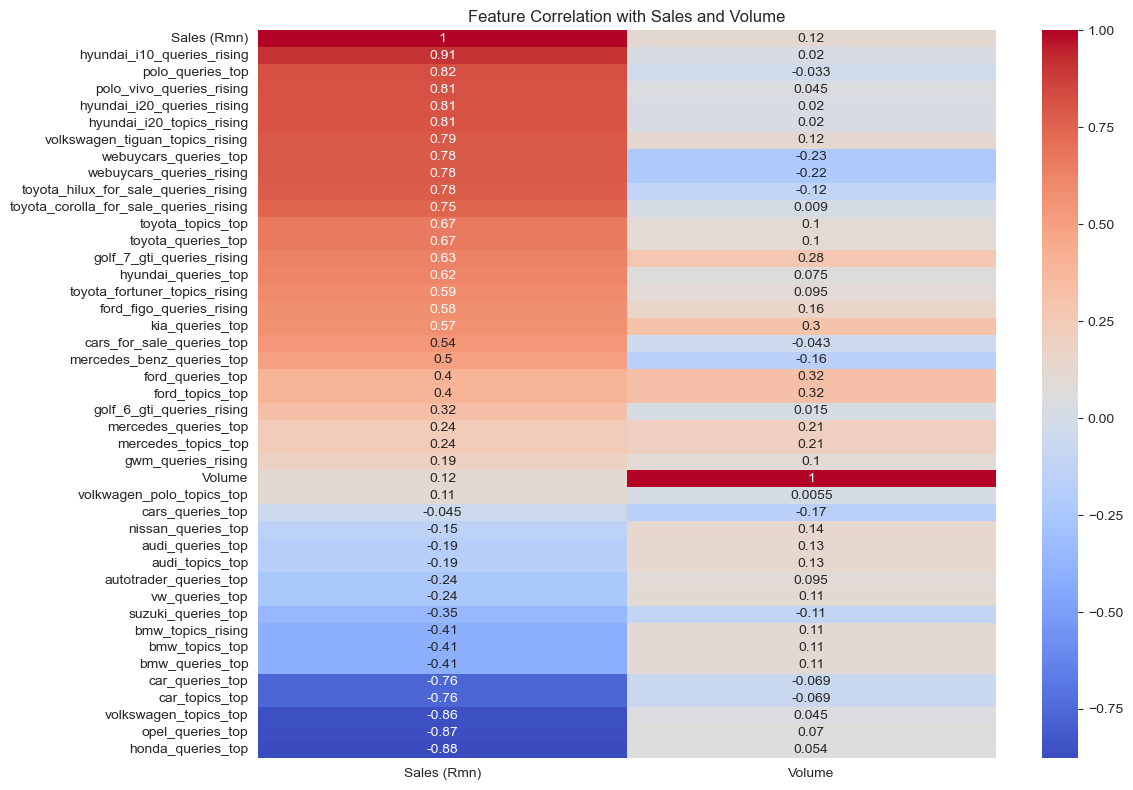

In [165]:
# Check correlations with Sales and Volume
correlation = final_df_scaled.corr(numeric_only=True)

# Heatmap of correlations with Sales and Volume
plt.figure(figsize=(12, 8))
sns.heatmap(correlation[['Sales (Rmn)', 'Volume']].sort_values(by='Sales (Rmn)', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Sales and Volume")
plt.tight_layout()
plt.show()

##### **Interpretation**

**Sales:**
+ There are a lot of strong positive and also negative correlations of the features to sales, which suggests that many of the features are good predictors for sales.

**Volume:**
+ Many features have weak correlation to Voolume which suggest that online search trends are poor predictors of volume compared to sales.

### d. Feature Importance/Selection

In [166]:
# Feature filtering function
def filter_features_by_importance(X, y, threshold=0.001, n_estimators=200, n_repeats=30, random_state=42):
    # Fit RandomForest model
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X, y)

    # Compute Permutation Importance
    pfi = permutation_importance(rf, X, y, n_repeats=n_repeats, random_state=random_state)

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': pfi.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Filter features based on threshold
    important_features = importance_df[importance_df['Importance'] > threshold]['Feature']
    X_filtered = X[important_features]

    # Reporting
    print(f"\nNumber of features before filtering: {X.shape[1]}")
    print(f"Number of features after filtering: {X_filtered.shape[1]}")
    print(f"Number of features dropped: {X.shape[1] - X_filtered.shape[1]}")
    print("="*50)
    print("Permutation Feature Importance Table:")
    X_filtered.info()

    return X_filtered

In [167]:
X1_train = filter_features_by_importance(X_train, y1_train, threshold=0.001)
X1_test = X_test[X1_train.columns]
X1_train_scaled = X_train_scaled[X1_train.columns]
X1_test_scaled = X_test_scaled[X1_train.columns]


Number of features before filtering: 41
Number of features after filtering: 40
Number of features dropped: 1
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   vw_queries_top                          203 non-null    int64
 1   hyundai_queries_top                     203 non-null    int64
 2   gwm_queries_rising                      203 non-null    int64
 3   autotrader_queries_top                  203 non-null    int64
 4   toyota_fortuner_topics_rising           203 non-null    int64
 5   mercedes_benz_queries_top               203 non-null    int64
 6   opel_queries_top                        203 non-null    int64
 7   nissan_queries_top                      203 non-null    int64
 8   honda_queries_top                       203 non-null 

In [168]:
X2_train = filter_features_by_importance(X_train, y2_train, threshold=0.005)
X2_test = X_test[X2_train.columns]
X2_train_scaled = X_train_scaled[X2_train.columns]
X2_test_scaled = X_test_scaled[X2_train.columns]


Number of features before filtering: 41
Number of features after filtering: 27
Number of features dropped: 14
Permutation Feature Importance Table:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2005-02-28 to 2021-12-31
Data columns (total 27 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   autotrader_queries_top                  203 non-null    int64
 1   suzuki_queries_top                      203 non-null    int64
 2   cars_queries_top                        203 non-null    int64
 3   cars_for_sale_queries_top               203 non-null    int64
 4   honda_queries_top                       203 non-null    int64
 5   gwm_queries_rising                      203 non-null    int64
 6   opel_queries_top                        203 non-null    int64
 7   volkswagen_topics_top                   203 non-null    int64
 8   ford_queries_top                        203 non-null

## 7. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>An extension of the non-seasonal ARIMA model, designed to handle data with seasonal patterns. It captures both short-term and long-term dependencies within the data</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>A variant of the regression version of the Support Vector Machines (SVM). It tries to fit a function that predicts future values while keeping prediction errors within a certain margin (ε-insensitive loss function).</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>A type of neural network that excels in this area. Unlike simple models, LSTMs can remember information for long periods, making them ideal for time series tasks where past data influences future values.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BI-LSTM</td>
      <td>An Extension of the LSTM model that integrates the input information from both past and future time steps. It's like predicting the middle words of a sentence by knowing both its first and last words.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines the CNNs power of learning local patterns in data, with the LSTMs ability to capture long-term dependencies in sequential data.</td>
      <td>Deep Learning</td>
    </tr>
  </tbody>
</table>

### a. Sales

##### i. SARIMA

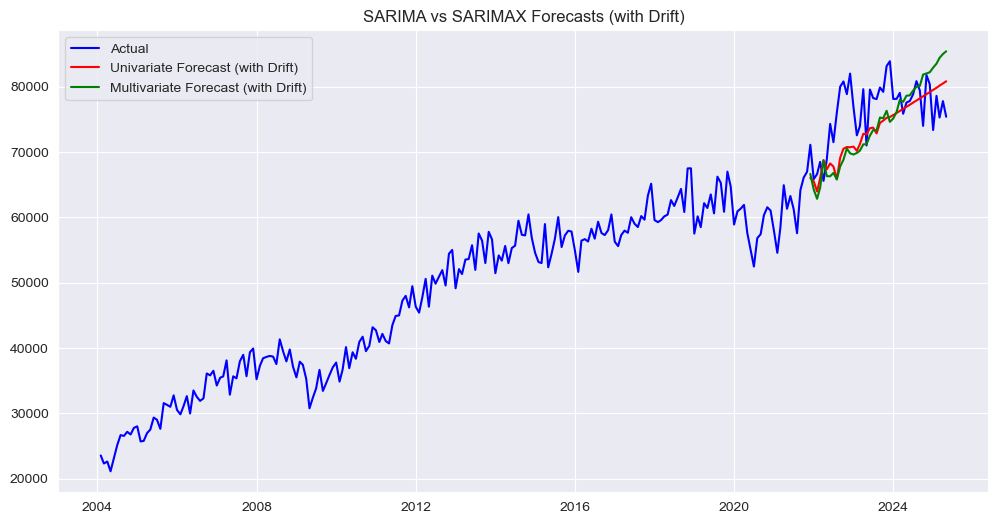

+-----------------------------+---------+---------+---------+---------+
|            Model            |   AIC   |   BIC   |   RMSE  |   MAE   |
+-----------------------------+---------+---------+---------+---------+
|  Univariate SARIMA (Drift)  | 3423.09 | 3439.25 | 5232.64 | 4313.21 |
| Multivariate SARIMA (Drift) | 3447.77 | 3554.39 | 6207.92 | 5085.53 |
+-----------------------------+---------+---------+---------+---------+

Best model based on RMSE: Univariate SARIMA (with Drift)


In [107]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable

'''
From Article 3 (Modelling and Forecasting the Impact of the COVID-19 Pandemic on 
South Africa’s New Car Sales) and Article 1 (Assessing and Forecasting the
Long-Term Impact of the Global Financial Crisis on New Car Sales in South Africa) 
we will be taking the SARIMA (0, 1, 1)(0, 0, 2)12 model architecture.
'''

# ===== Univariate SARIMA with Drift =====
def train_sarima_univariate(y, order=(0,1,1), seasonal_order=(0,0,2,12), steps=None, trend="t"):
    if steps is None:
        raise ValueError("You must provide steps (e.g., len(test set))")

    model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                    trend=trend,  # <--- drift added
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return results, forecast_mean, conf_int


# ===== Multivariate SARIMAX with Drift =====
def train_sarima_with_exog(y, exog, order=(0,1,1), seasonal_order=(0,0,2,12),
                           steps=None, exog_future=None, trend="t"):
    if steps is None:
        raise ValueError("You must provide steps (e.g., len(test set))")

    model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order,
                    trend=trend,  # <--- drift added
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=steps, exog=exog_future)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return results, forecast_mean, conf_int


# ===== Example Usage =====
steps = len(X1_test)

# Univariate SARIMA
sarima_uni, forecast_uni, conf_uni = train_sarima_univariate(y1_train, steps=steps)

# Multivariate SARIMAX
sarima_multi, forecast_multi, conf_multi = train_sarima_with_exog(y1_train, X1_train, steps=steps, exog_future=X1_test)

# ===== Compare Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1, label="Actual", color="blue")
plt.plot(y1_test.index, forecast_uni, label="Univariate Forecast (with Drift)", color="red")
plt.plot(y1_test.index, forecast_multi, label="Multivariate Forecast (with Drift)", color="green")
plt.legend()
plt.title("SARIMA vs SARIMAX Forecasts (with Drift)")
plt.show()

# ===== Evaluate Forecasts =====
actual = y1_test

rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))

mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

# AIC & BIC
aic_uni, bic_uni = sarima_uni.aic, sarima_uni.bic
aic_multi, bic_multi = sarima_multi.aic, sarima_multi.bic

# Best model by RMSE
best_model = "Univariate SARIMA (with Drift)" if rmse_uni < rmse_multi else "Multivariate SARIMA (with Drift)"

# ===== PrettyTable =====
table = PrettyTable()
table.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

table.add_row(["Univariate SARIMA (Drift)",
               f"{aic_uni:.2f}", f"{bic_uni:.2f}",
               f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])

table.add_row(["Multivariate SARIMA (Drift)",
               f"{aic_multi:.2f}", f"{bic_multi:.2f}",
               f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])

print(table)
print(f"\nBest model based on RMSE: {best_model}")

In [250]:
# # ===== Hyperparameter Grid =====
# p = d = q = range(0, 2)         # AR, differencing, MA terms
# P = D = Q = range(0, 2)         # Seasonal AR, differencing, MA
# s = 12                          # seasonal period
# trend_options = ['n', 'c', 't'] # no trend, constant, drift
# 
# # Generate all combinations
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(P, D, Q, [s]))
# 
# # ===== Function for Grid Search (Univariate SARIMA) =====
# def tune_sarima_univariate(y, steps, pdq_list, seasonal_pdq_list, trend_list=['t']):
#     best_aic = np.inf
#     best_order = None
#     best_seasonal = None
#     best_trend = None
#     best_model = None
# 
#     for order in pdq_list:
#         for seasonal_order in seasonal_pdq_list:
#             for trend in trend_list:
#                 try:
#                     model = SARIMAX(y, order=order, seasonal_order=seasonal_order,
#                                     trend=trend, enforce_stationarity=False,
#                                     enforce_invertibility=False)
#                     results = model.fit(disp=False)
#                     if results.aic < best_aic:
#                         best_aic = results.aic
#                         best_order = order
#                         best_seasonal = seasonal_order
#                         best_trend = trend
#                         best_model = results
#                 except:
#                     continue
#     # Forecast
#     forecast = best_model.get_forecast(steps=steps)
#     forecast_mean = forecast.predicted_mean
#     conf_int = forecast.conf_int()
# 
#     return best_model, forecast_mean, conf_int, best_order, best_seasonal, best_trend
# 
# # ===== Function for Grid Search (Multivariate SARIMAX) =====
# def tune_sarima_with_exog(y, exog, steps, exog_future, pdq_list, seasonal_pdq_list, trend_list=['t']):
#     best_aic = np.inf
#     best_order = None
#     best_seasonal = None
#     best_trend = None
#     best_model = None
# 
#     for order in pdq_list:
#         for seasonal_order in seasonal_pdq_list:
#             for trend in trend_list:
#                 try:
#                     model = SARIMAX(y, exog=exog, order=order, seasonal_order=seasonal_order,
#                                     trend=trend, enforce_stationarity=False,
#                                     enforce_invertibility=False)
#                     results = model.fit(disp=False)
#                     if results.aic < best_aic:
#                         best_aic = results.aic
#                         best_order = order
#                         best_seasonal = seasonal_order
#                         best_trend = trend
#                         best_model = results
#                 except:
#                     continue
#     # Forecast using future exogenous variables
#     forecast = best_model.get_forecast(steps=steps, exog=exog_future)
#     forecast_mean = forecast.predicted_mean
#     conf_int = forecast.conf_int()
# 
#     return best_model, forecast_mean, conf_int, best_order, best_seasonal, best_trend
# 
# # ===== Example Usage =====
# steps = len(X1_test)
# 
# # Univariate
# sarima_uni, forecast_uni, conf_uni, best_order_uni, best_seasonal_uni, best_trend_uni = \
#     tune_sarima_univariate(y1_train, steps, pdq, seasonal_pdq, trend_options)
# 
# # Multivariate
# sarima_multi, forecast_multi, conf_multi, best_order_multi, best_seasonal_multi, best_trend_multi = \
#     tune_sarima_with_exog(y1_train, X1_train, steps, X1_test, pdq, seasonal_pdq, trend_options)
# 
# # ===== Plot Forecasts =====
# plt.figure(figsize=(12,6))
# plt.plot(y1, label="Actual")
# plt.plot(forecast_uni, label="Univariate Forecast", color="red")
# plt.plot(forecast_multi, label="Multivariate Forecast", color="green")
# plt.legend()
# plt.title("SARIMA vs SARIMAX Forecasts")
# plt.show()
# 
# # ===== Evaluate Forecasts =====
# actual = y1_test
# 
# rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
# rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))
# 
# mae_uni = mean_absolute_error(actual, forecast_uni)
# mae_multi = mean_absolute_error(actual, forecast_multi)
# 
# aic_uni, bic_uni = sarima_uni.aic, sarima_uni.bic
# aic_multi, bic_multi = sarima_multi.aic, sarima_multi.bic
# 
# # ===== Rank Best Model =====
# best_model_name = "Univariate SARIMA" if rmse_uni < rmse_multi else "Multivariate SARIMA"
# 
# # ===== PrettyTable =====
# table = PrettyTable()
# table.field_names = ["Model", "Order", "Seasonal_Order", "Trend", "AIC", "BIC", "RMSE", "MAE"]
# 
# table.add_row(["Univariate SARIMA", best_order_uni, best_seasonal_uni, best_trend_uni,
#                f"{aic_uni:.2f}", f"{bic_uni:.2f}", f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])
# 
# table.add_row(["Multivariate SARIMA", best_order_multi, best_seasonal_multi, best_trend_multi,
#                f"{aic_multi:.2f}", f"{bic_multi:.2f}", f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])
# 
# print(table)
# print(f"\nBest model based on RMSE: {best_model_name}")
# 

###### *Still need to decide if I should use hyperparameter tuning or the model architecture from the Articles*

##### ii. LSSVR

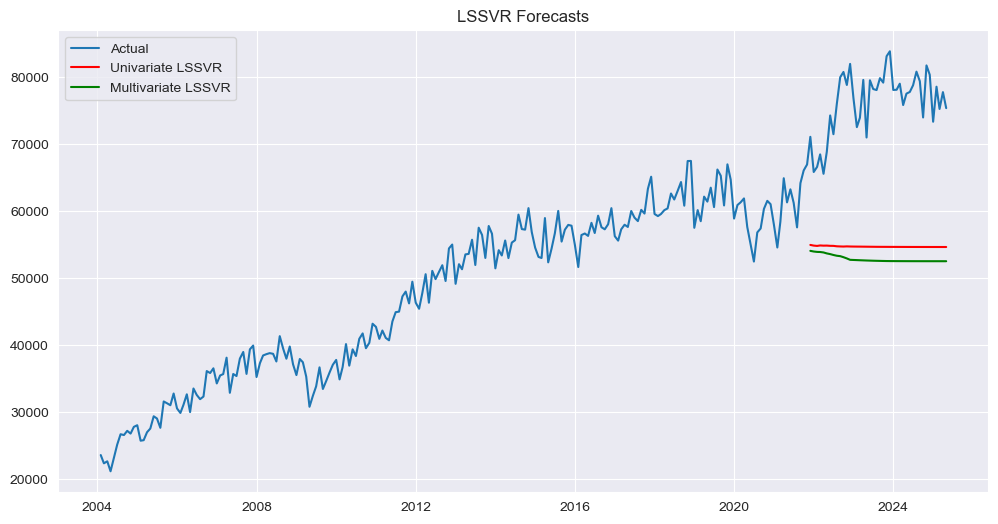


=== Selected Hyperparameters ===
+--------------------+--------+-----+-------+------+
|       Model        | Kernel |  C  | Gamma | Lags |
+--------------------+--------+-----+-------+------+
|  Univariate LSSVR  |  rbf   | 100 | scale |  12  |
| Multivariate LSSVR |  rbf   | 100 | scale |  12  |
+--------------------+--------+-----+-------+------+

=== Model Performance ===
+--------------------+--------+--------+----------+----------+
|       Model        |  AIC   |  BIC   |   RMSE   |   MAE    |
+--------------------+--------+--------+----------+----------+
|  Univariate LSSVR  | 854.58 | 877.17 | 22165.86 | 21672.16 |
| Multivariate LSSVR | 916.16 | 987.41 | 24039.90 | 23520.16 |
+--------------------+--------+--------+----------+----------+

Best model based on RMSE: Univariate LSSVR


In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable

# ===== Helper to create lag features =====
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df = df.dropna()
    return df

# ===== Approximate log-likelihood, AIC, BIC for ML models =====
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

# ===== Univariate LSSVR =====
def train_lssvr_univariate(y_train, y_test, lags=12, param_grid=None):
    if param_grid is None:
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }

    # Create lagged features
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values
    y_train_lag = train_df["y"].values

    # Grid search with time-series split
    tscv = TimeSeriesSplit(n_splits=5)
    svr = SVR(kernel="rbf")
    grid = GridSearchCV(svr, param_grid, cv=tscv, scoring="neg_mean_squared_error")
    grid.fit(X_train, y_train_lag)

    best_params = grid.best_params_
    best_model = grid.best_estimator_

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape(1, -1)
        y_pred = best_model.predict(X_pred)[0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    return best_model, np.array(forecast), best_params, lags

# ===== Multivariate LSSVR =====
def train_lssvr_multivariate(y_train, X_train, X_test, lags=12, param_grid=None):
    if param_grid is None:
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1]
        }

    # Create lagged y features
    y_train_lagged = create_lags(y_train, lags)
    X_train_lagged = X_train.iloc[lags:].reset_index(drop=True)

    # Align lengths
    min_len = min(len(y_train_lagged), len(X_train_lagged))
    y_train_lagged = y_train_lagged.iloc[-min_len:]
    X_train_lagged = X_train_lagged.iloc[-min_len:]

    # Combine features
    X_train_final = np.hstack([y_train_lagged.drop("y", axis=1).values, X_train_lagged.values])
    y_train_final = y_train_lagged["y"].values

    # Grid search
    tscv = TimeSeriesSplit(n_splits=5)
    svr = SVR(kernel="rbf")
    grid = GridSearchCV(svr, param_grid, cv=tscv, scoring="neg_mean_squared_error")
    grid.fit(X_train_final, y_train_final)

    best_params = grid.best_params_
    best_model = grid.best_estimator_

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for i in range(len(X_test)):
        X_pred = np.array(last_window[-lags:] + X_test.iloc[i].tolist()).reshape(1, -1)
        y_pred = best_model.predict(X_pred)[0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    return best_model, np.array(forecast), best_params, lags

# ===== Example Usage =====
lags = 12

# Univariate
lssvr_uni, forecast_uni, best_params_uni, best_lags_uni = train_lssvr_univariate(y1_train, y1_test, lags)

# Multivariate
lssvr_multi, forecast_multi, best_params_multi, best_lags_multi = train_lssvr_multivariate(y1_train, X1_train, X1_test, lags)

# ===== Plot Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1.index, y1, label="Actual")
plt.plot(y1_test.index, forecast_uni, label="Univariate LSSVR", color="red")
plt.plot(y1_test.index, forecast_multi, label="Multivariate LSSVR", color="green")
plt.legend()
plt.title("LSSVR Forecasts")
plt.show()

# ===== Evaluate Forecasts =====
actual = y1_test

# Metrics
rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))
mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

# AIC & BIC (approximation, k = #params = lags + 1)
aic_uni, bic_uni = calculate_aic_bic(actual, forecast_uni, k=best_lags_uni+1)
aic_multi, bic_multi = calculate_aic_bic(actual, forecast_multi, k=best_lags_multi+1+X1_train.shape[1])

# ===== Table 1: Hyperparameters (Reproducibility) =====
table1 = PrettyTable()
table1.field_names = ["Model", "Kernel", "C", "Gamma", "Lags"]

table1.add_row(["Univariate LSSVR", "rbf", best_params_uni["C"], best_params_uni["gamma"], best_lags_uni])
table1.add_row(["Multivariate LSSVR", "rbf", best_params_multi["C"], best_params_multi["gamma"], best_lags_multi])
print("\n=== Selected Hyperparameters ===")
print(table1)

# ===== Table 2: Model Performance =====
table2 = PrettyTable()
table2.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

table2.add_row(["Univariate LSSVR",
               f"{aic_uni:.2f}", f"{bic_uni:.2f}",
               f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])

table2.add_row(["Multivariate LSSVR",
               f"{aic_multi:.2f}", f"{bic_multi:.2f}",
               f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])

print("\n=== Model Performance ===")
print(table2)

best_model_name = "Univariate LSSVR" if rmse_uni < rmse_multi else "Multivariate LSSVR"
print(f"\nBest model based on RMSE: {best_model_name}")

##### iii. LSTM

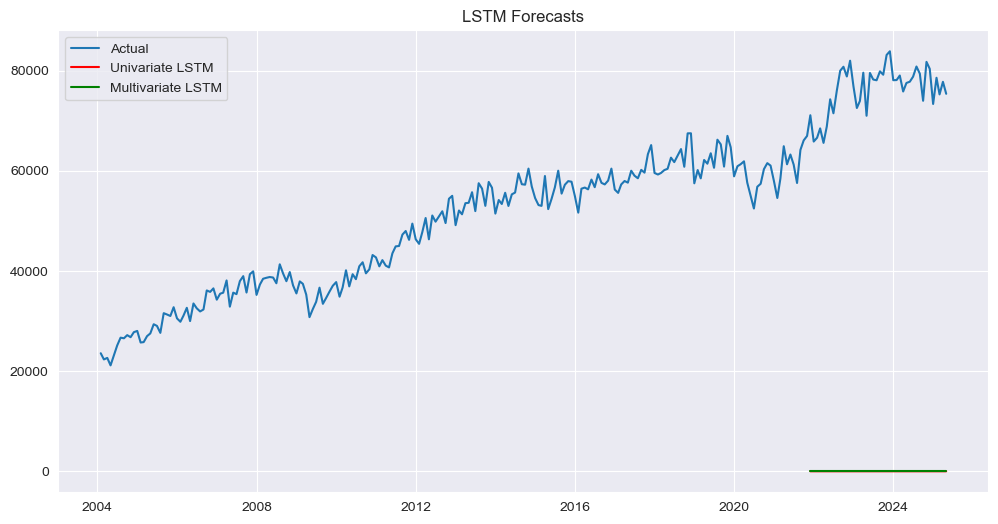


=== Selected Hyperparameters ===
+-------------------+-------+---------------+--------+------------+------+
|       Model       | Units | Learning Rate | Epochs | Batch Size | Lags |
+-------------------+-------+---------------+--------+------------+------+
|  Univariate LSTM  |   50  |     0.001     |   20   |     16     |  12  |
| Multivariate LSTM |   50  |     0.001     |   20   |     16     |  12  |
+-------------------+-------+---------------+--------+------------+------+

=== Model Performance ===
+-------------------+---------+---------+----------+----------+
|       Model       |   AIC   |   BIC   |   RMSE   |   MAE    |
+-------------------+---------+---------+----------+----------+
|  Univariate LSTM  |  951.58 | 1059.32 | 76531.28 | 76393.08 |
| Multivariate LSTM | 1007.58 | 1163.97 | 76512.27 | 76374.05 |
+-------------------+---------+---------+----------+----------+

Best model based on RMSE: Multivariate LSTM


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# ===== Helper to create lag features =====
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df = df.dropna()
    return df

# ===== AIC/BIC Approximation =====
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

# ===== Build simple LSTM model =====
def build_lstm(input_shape, units=50, lr=0.001):
    model = Sequential()
    model.add(LSTM(units, activation="tanh", input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# ===== Univariate LSTM =====
def train_lstm_univariate(y_train, y_test, lags=12, epochs=20, batch_size=16, units=50, lr=0.001):
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values
    y_train_lag = train_df["y"].values

    # Reshape to [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and train LSTM
    model = build_lstm((X_train.shape[1], X_train.shape[2]), units, lr)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape((1, lags, 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Multivariate LSTM =====
def train_lstm_multivariate(y_train, X_train, X_test, lags=12, epochs=20, batch_size=16, units=50, lr=0.001):
    y_train_lagged = create_lags(y_train, lags)
    X_train_lagged = X_train.iloc[lags:].reset_index(drop=True)

    # Align lengths
    min_len = min(len(y_train_lagged), len(X_train_lagged))
    y_train_lagged = y_train_lagged.iloc[-min_len:]
    X_train_lagged = X_train_lagged.iloc[-min_len:]

    # Combine features
    X_train_final = np.hstack([y_train_lagged.drop("y", axis=1).values, X_train_lagged.values])
    y_train_final = y_train_lagged["y"].values

    # Reshape for LSTM
    X_train_final = X_train_final.reshape((X_train_final.shape[0], X_train_final.shape[1], 1))

    # Build and train LSTM
    model = build_lstm((X_train_final.shape[1], 1), units, lr)
    model.fit(X_train_final, y_train_final, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for i in range(len(X_test)):
        features = np.array(last_window[-lags:] + X_test.iloc[i].tolist())
        X_pred = features.reshape((1, len(features), 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Example Usage =====
lags = 12
y_train, y_test = y1_train, y1_test

# Univariate
lstm_uni, forecast_uni, best_params_uni, best_lags_uni = train_lstm_univariate(y_train, y_test, lags)

# Multivariate
lstm_multi, forecast_multi, best_params_multi, best_lags_multi = train_lstm_multivariate(y_train, X1_train, X1_test, lags)

# ===== Plot Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1.index, y1, label="Actual")
plt.plot(y_test.index, forecast_uni, label="Univariate LSTM", color="red")
plt.plot(y_test.index, forecast_multi, label="Multivariate LSTM", color="green")
plt.legend()
plt.title("LSTM Forecasts")
plt.show()

# ===== Evaluate Forecasts =====
actual = y_test

# Metrics
rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))
mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

# AIC & BIC approximation (k = parameters ~ lags + hidden units)
aic_uni, bic_uni = calculate_aic_bic(actual, forecast_uni, k=best_lags_uni + best_params_uni["units"])
aic_multi, bic_multi = calculate_aic_bic(actual, forecast_multi, k=best_lags_multi + best_params_multi["units"] + X1_train.shape[1])

# ===== Table 1: Hyperparameters =====
table1 = PrettyTable()
table1.field_names = ["Model", "Units", "Learning Rate", "Epochs", "Batch Size", "Lags"]

table1.add_row(["Univariate LSTM", best_params_uni["units"], best_params_uni["lr"], 
                best_params_uni["epochs"], best_params_uni["batch_size"], best_lags_uni])
table1.add_row(["Multivariate LSTM", best_params_multi["units"], best_params_multi["lr"], 
                best_params_multi["epochs"], best_params_multi["batch_size"], best_lags_multi])

print("\n=== Selected Hyperparameters ===")
print(table1)

# ===== Table 2: Model Performance =====
table2 = PrettyTable()
table2.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

table2.add_row(["Univariate LSTM",
               f"{aic_uni:.2f}", f"{bic_uni:.2f}",
               f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])

table2.add_row(["Multivariate LSTM",
               f"{aic_multi:.2f}", f"{bic_multi:.2f}",
               f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])

print("\n=== Model Performance ===")
print(table2)

best_model_name = "Univariate LSTM" if rmse_uni < rmse_multi else "Multivariate LSTM"
print(f"\nBest model based on RMSE: {best_model_name}")

##### iv. Bi-LSTM

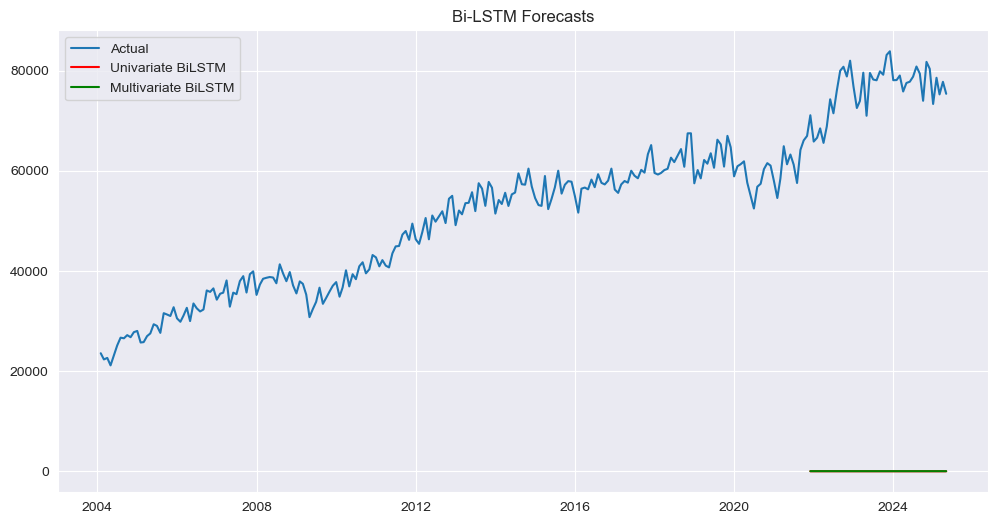


=== Selected Hyperparameters ===
+---------------------+-------+---------------+--------+------------+------+
|        Model        | Units | Learning Rate | Epochs | Batch Size | Lags |
+---------------------+-------+---------------+--------+------------+------+
|  Univariate BiLSTM  |   50  |     0.001     |   20   |     16     |  12  |
| Multivariate BiLSTM |   50  |     0.001     |   20   |     16     |  12  |
+---------------------+-------+---------------+--------+------------+------+

=== Model Performance ===
+---------------------+---------+---------+----------+----------+
|        Model        |   AIC   |   BIC   |   RMSE   |   MAE    |
+---------------------+---------+---------+----------+----------+
|  Univariate BiLSTM  |  951.59 | 1059.33 | 76528.52 | 76390.27 |
| Multivariate BiLSTM | 1007.59 | 1163.98 | 76508.67 | 76370.40 |
+---------------------+---------+---------+----------+----------+

Best model based on RMSE: Multivariate BiLSTM


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

# ===== Helper to create lag features =====
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df = df.dropna()
    return df

# ===== AIC/BIC Approximation =====
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

# ===== Build Bi-LSTM model =====
def build_bilstm(input_shape, units=50, lr=0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(units, activation="tanh"), input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# ===== Univariate Bi-LSTM =====
def train_bilstm_univariate(y_train, y_test, lags=12, epochs=20, batch_size=16, units=50, lr=0.001):
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values
    y_train_lag = train_df["y"].values

    # Reshape to [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and train BiLSTM
    model = build_bilstm((X_train.shape[1], X_train.shape[2]), units, lr)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape((1, lags, 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Multivariate Bi-LSTM =====
def train_bilstm_multivariate(y_train, X_train, X_test, lags=12, epochs=20, batch_size=16, units=50, lr=0.001):
    y_train_lagged = create_lags(y_train, lags)
    X_train_lagged = X_train.iloc[lags:].reset_index(drop=True)

    # Align lengths
    min_len = min(len(y_train_lagged), len(X_train_lagged))
    y_train_lagged = y_train_lagged.iloc[-min_len:]
    X_train_lagged = X_train_lagged.iloc[-min_len:]

    # Combine features
    X_train_final = np.hstack([y_train_lagged.drop("y", axis=1).values, X_train_lagged.values])
    y_train_final = y_train_lagged["y"].values

    # Reshape for BiLSTM
    X_train_final = X_train_final.reshape((X_train_final.shape[0], X_train_final.shape[1], 1))

    # Build and train BiLSTM
    model = build_bilstm((X_train_final.shape[1], 1), units, lr)
    model.fit(X_train_final, y_train_final, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for i in range(len(X_test)):
        features = np.array(last_window[-lags:] + X_test.iloc[i].tolist())
        X_pred = features.reshape((1, len(features), 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Example Usage =====
lags = 12
y_train, y_test = y1_train, y1_test

# Univariate
bilstm_uni, forecast_uni, best_params_uni, best_lags_uni = train_bilstm_univariate(y_train, y_test, lags)

# Multivariate
bilstm_multi, forecast_multi, best_params_multi, best_lags_multi = train_bilstm_multivariate(y_train, X1_train, X1_test, lags)

# ===== Plot Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1.index, y1, label="Actual")
plt.plot(y_test.index, forecast_uni, label="Univariate BiLSTM", color="red")
plt.plot(y_test.index, forecast_multi, label="Multivariate BiLSTM", color="green")
plt.legend()
plt.title("Bi-LSTM Forecasts")
plt.show()

# ===== Evaluate Forecasts =====
actual = y_test

# Metrics
rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))
mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

# AIC & BIC approximation (k = parameters ~ lags + hidden units)
aic_uni, bic_uni = calculate_aic_bic(actual, forecast_uni, k=best_lags_uni + best_params_uni["units"])
aic_multi, bic_multi = calculate_aic_bic(actual, forecast_multi, k=best_lags_multi + best_params_multi["units"] + X1_train.shape[1])

# ===== Table 1: Hyperparameters =====
table1 = PrettyTable()
table1.field_names = ["Model", "Units", "Learning Rate", "Epochs", "Batch Size", "Lags"]

table1.add_row(["Univariate BiLSTM", best_params_uni["units"], best_params_uni["lr"], 
                best_params_uni["epochs"], best_params_uni["batch_size"], best_lags_uni])
table1.add_row(["Multivariate BiLSTM", best_params_multi["units"], best_params_multi["lr"], 
                best_params_multi["epochs"], best_params_multi["batch_size"], best_lags_multi])

print("\n=== Selected Hyperparameters ===")
print(table1)

# ===== Table 2: Model Performance =====
table2 = PrettyTable()
table2.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

table2.add_row(["Univariate BiLSTM",
               f"{aic_uni:.2f}", f"{bic_uni:.2f}",
               f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])

table2.add_row(["Multivariate BiLSTM",
               f"{aic_multi:.2f}", f"{bic_multi:.2f}",
               f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])

print("\n=== Model Performance ===")
print(table2)

best_model_name = "Univariate BiLSTM" if rmse_uni < rmse_multi else "Multivariate BiLSTM"
print(f"\nBest model based on RMSE: {best_model_name}")

##### v. CNN-LSTM

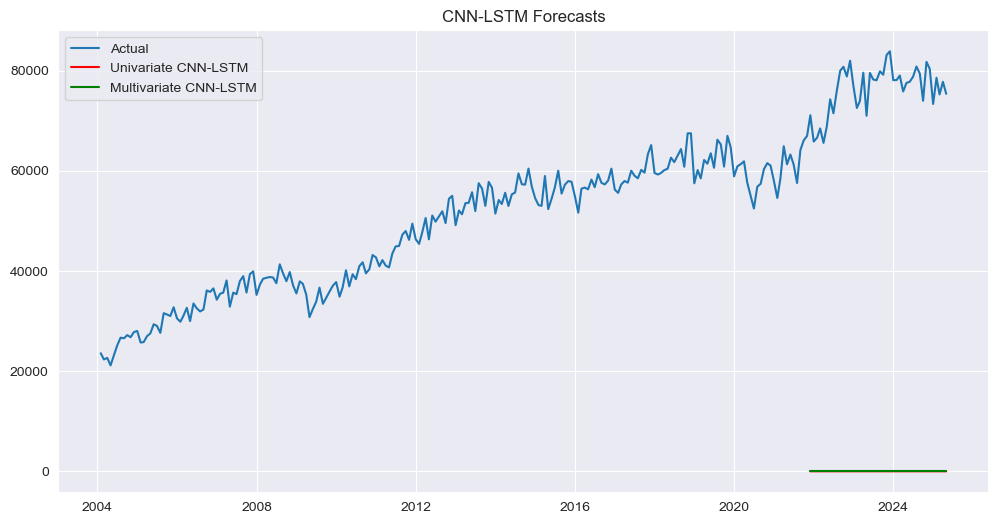


=== Selected Hyperparameters ===
+-----------------------+---------+--------+------+-------+-------+--------+-------+------+
|         Model         | Filters | Kernel | Pool | Units |   LR  | Epochs | Batch | Lags |
+-----------------------+---------+--------+------+-------+-------+--------+-------+------+
|  Univariate CNN-LSTM  |    64   |   3    |  2   |   50  | 0.001 |   20   |   16  |  12  |
| Multivariate CNN-LSTM |    64   |   3    |  2   |   50  | 0.001 |   20   |   16  |  12  |
+-----------------------+---------+--------+------+-------+-------+--------+-------+------+

=== Model Performance ===
+-----------------------+---------+---------+----------+----------+
|         Model         |   AIC   |   BIC   |   RMSE   |   MAE    |
+-----------------------+---------+---------+----------+----------+
|  Univariate CNN-LSTM  | 1079.58 | 1298.53 | 76531.24 | 76393.03 |
| Multivariate CNN-LSTM | 1135.58 | 1403.18 | 76512.58 | 76374.36 |
+-----------------------+---------+---------+--

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prettytable import PrettyTable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

# ===== Helper to create lag features =====
def create_lags(y, lags=12):
    df = pd.DataFrame({'y': y})
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df['y'].shift(i)
    df = df.dropna()
    return df

# ===== AIC/BIC Approximation =====
def calculate_aic_bic(y_true, y_pred, k):
    n = len(y_true)
    resid = y_true - y_pred
    sigma2 = np.var(resid)
    loglik = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * k - 2 * loglik
    bic = np.log(n) * k - 2 * loglik
    return aic, bic

# ===== Build CNN-LSTM model =====
def build_cnn_lstm(input_shape, filters=64, kernel_size=3, pool_size=2, units=50, lr=0.001):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(units, activation="tanh"))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# ===== Univariate CNN-LSTM =====
def train_cnnlstm_univariate(y_train, y_test, lags=12, epochs=20, batch_size=16, 
                             filters=64, kernel_size=3, pool_size=2, units=50, lr=0.001):
    train_df = create_lags(y_train, lags)
    X_train = train_df.drop("y", axis=1).values
    y_train_lag = train_df["y"].values

    # Reshape to [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Build and train CNN-LSTM
    model = build_cnn_lstm((X_train.shape[1], X_train.shape[2]), filters, kernel_size, pool_size, units, lr)
    model.fit(X_train, y_train_lag, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for _ in range(len(y_test)):
        X_pred = np.array(last_window[-lags:]).reshape((1, lags, 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"filters": filters, "kernel_size": kernel_size, "pool_size": pool_size,
                   "units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Multivariate CNN-LSTM =====
def train_cnnlstm_multivariate(y_train, X_train, X_test, lags=12, epochs=20, batch_size=16,
                               filters=64, kernel_size=3, pool_size=2, units=50, lr=0.001):
    y_train_lagged = create_lags(y_train, lags)
    X_train_lagged = X_train.iloc[lags:].reset_index(drop=True)

    # Align lengths
    min_len = min(len(y_train_lagged), len(X_train_lagged))
    y_train_lagged = y_train_lagged.iloc[-min_len:]
    X_train_lagged = X_train_lagged.iloc[-min_len:]

    # Combine features
    X_train_final = np.hstack([y_train_lagged.drop("y", axis=1).values, X_train_lagged.values])
    y_train_final = y_train_lagged["y"].values

    # Reshape for CNN-LSTM
    X_train_final = X_train_final.reshape((X_train_final.shape[0], X_train_final.shape[1], 1))

    # Build and train CNN-LSTM
    model = build_cnn_lstm((X_train_final.shape[1], 1), filters, kernel_size, pool_size, units, lr)
    model.fit(X_train_final, y_train_final, epochs=epochs, batch_size=batch_size, verbose=0)

    # Recursive forecast
    forecast = []
    last_window = y_train[-lags:].tolist()
    for i in range(len(X_test)):
        features = np.array(last_window[-lags:] + X_test.iloc[i].tolist())
        X_pred = features.reshape((1, len(features), 1))
        y_pred = model.predict(X_pred, verbose=0)[0,0]
        forecast.append(y_pred)
        last_window.append(y_pred)

    best_params = {"filters": filters, "kernel_size": kernel_size, "pool_size": pool_size,
                   "units": units, "lr": lr, "epochs": epochs, "batch_size": batch_size}
    return model, np.array(forecast), best_params, lags

# ===== Example Usage =====
lags = 12
y_train, y_test = y1_train, y1_test

# Univariate
cnnlstm_uni, forecast_uni, best_params_uni, best_lags_uni = train_cnnlstm_univariate(y_train, y_test, lags)

# Multivariate
cnnlstm_multi, forecast_multi, best_params_multi, best_lags_multi = train_cnnlstm_multivariate(y_train, X1_train, X1_test, lags)

# ===== Plot Forecasts =====
plt.figure(figsize=(12,6))
plt.plot(y1.index, y1, label="Actual")
plt.plot(y_test.index, forecast_uni, label="Univariate CNN-LSTM", color="red")
plt.plot(y_test.index, forecast_multi, label="Multivariate CNN-LSTM", color="green")
plt.legend()
plt.title("CNN-LSTM Forecasts")
plt.show()

# ===== Evaluate Forecasts =====
actual = y_test

# Metrics
rmse_uni = np.sqrt(mean_squared_error(actual, forecast_uni))
rmse_multi = np.sqrt(mean_squared_error(actual, forecast_multi))
mae_uni = mean_absolute_error(actual, forecast_uni)
mae_multi = mean_absolute_error(actual, forecast_multi)

# AIC & BIC approximation (k ~ lags + hidden units + conv filters)
aic_uni, bic_uni = calculate_aic_bic(actual, forecast_uni, k=best_lags_uni + best_params_uni["units"] + best_params_uni["filters"])
aic_multi, bic_multi = calculate_aic_bic(actual, forecast_multi, k=best_lags_multi + best_params_multi["units"] + best_params_multi["filters"] + X1_train.shape[1])

# ===== Table 1: Hyperparameters =====
table1 = PrettyTable()
table1.field_names = ["Model", "Filters", "Kernel", "Pool", "Units", "LR", "Epochs", "Batch", "Lags"]

table1.add_row(["Univariate CNN-LSTM", best_params_uni["filters"], best_params_uni["kernel_size"], 
                best_params_uni["pool_size"], best_params_uni["units"], best_params_uni["lr"], 
                best_params_uni["epochs"], best_params_uni["batch_size"], best_lags_uni])

table1.add_row(["Multivariate CNN-LSTM", best_params_multi["filters"], best_params_multi["kernel_size"], 
                best_params_multi["pool_size"], best_params_multi["units"], best_params_multi["lr"], 
                best_params_multi["epochs"], best_params_multi["batch_size"], best_lags_multi])

print("\n=== Selected Hyperparameters ===")
print(table1)

# ===== Table 2: Model Performance =====
table2 = PrettyTable()
table2.field_names = ["Model", "AIC", "BIC", "RMSE", "MAE"]

table2.add_row(["Univariate CNN-LSTM",
               f"{aic_uni:.2f}", f"{bic_uni:.2f}",
               f"{rmse_uni:.2f}", f"{mae_uni:.2f}"])

table2.add_row(["Multivariate CNN-LSTM",
               f"{aic_multi:.2f}", f"{bic_multi:.2f}",
               f"{rmse_multi:.2f}", f"{mae_multi:.2f}"])

print("\n=== Model Performance ===")
print(table2)

best_model_name = "Univariate CNN-LSTM" if rmse_uni < rmse_multi else "Multivariate CNN-LSTM"
print(f"\nBest model based on RMSE: {best_model_name}")

### b. Volume